### install packages

In [ ]:
!pip install gdown

### import libraries

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import shap
import sklearn
import statsmodels.api as sm
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import re
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras import optimizers, metrics, callbacks
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import r2_score


### dataset loading

In [ ]:
!gdown --id 1_2cFE058y8ATEr7g1uS9W1i7dphsmYTo

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_2cFE058y8ATEr7g1uS9W1i7dphsmYTo
To: /content/listings.csv
100% 12.9M/12.9M [00:00<00:00, 50.6MB/s]


In [ ]:
path_gdown_notebook="listings.csv"

In [ ]:
data_listings = pd.read_csv(path_gdown_notebook)

### DEPENDENT VARIABLE : price

In [ ]:
def transform_to_float(column_with_dollar_signs):
    # Remove dollar signs and commas, then convert to float
    float_column = [float(str(value).replace('$', '').replace(',', '')) for value in column_with_dollar_signs]
    return float_column


In [ ]:
data_listings.loc[:,'price']=transform_to_float(data_listings['price'])
data_listings['price']=data_listings['price'].astype(float)

In [ ]:
print(data_listings.price.describe())
len(data_listings)

count      8708.000000
mean       3979.619775
std       11156.265693
min         240.000000
25%        1727.000000
50%        2511.000000
75%        3864.000000
max      641055.000000
Name: price, dtype: float64


9388

In [ ]:
# percent of rows with price na
(data_listings.price.isna().sum() / len(data_listings)) * 100

7.243289305496378

In [ ]:
# df dataframe for further working with only rows that has price in it
df=data_listings.loc[data_listings['price'].isna()==False]

#### INDEPENDENT VARIABLES

In [ ]:
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 75, dtype: object

##### Numeric

In [ ]:
numeric_columns = data_listings.select_dtypes(include='number').columns.tolist()

In [ ]:
# percentages of na values in numeric columns
column_percentages=(data_listings[numeric_columns].isna().sum()/len(data_listings.index)*100).sort_values(ascending=False)
column_percentages

bathrooms                                       100.000000
description                                     100.000000
license                                         100.000000
calendar_updated                                100.000000
neighbourhood_group_cleansed                    100.000000
bedrooms                                        100.000000
reviews_per_month                                10.939497
review_scores_accuracy                           10.875586
review_scores_cleanliness                        10.875586
review_scores_checkin                            10.875586
review_scores_location                           10.875586
review_scores_value                              10.875586
review_scores_communication                      10.864934
review_scores_rating                             10.864934
price                                             7.243289
beds                                              1.629740
maximum_maximum_nights                            0.0106

In [ ]:
# Filter the columns where the percentage is more than 20 percent
selected_na_columns = column_percentages[column_percentages > 20].index.tolist()

# Print the selected column names
print(selected_na_columns)

['bathrooms', 'description', 'license', 'calendar_updated', 'neighbourhood_group_cleansed', 'bedrooms']


In [ ]:
df[selected_na_columns].describe()

,bathrooms,description,license,calendar_updated,neighbourhood_group_cleansed,bedrooms
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df1 dataframe with dropped columns that have all na values in it
df1=df[numeric_columns].drop(columns=selected_na_columns)

In [ ]:
# df@ dataframe that drops big percentage of unique values or small when it is scrape_id
print(((df1.nunique()/len(df1.index))*100).sort_values(ascending=False).head(15))
print(((df1.nunique()/len(df1.index))*100).sort_values(ascending=False).tail(15))
df2=df1.drop(columns=['id','scrape_id','host_id','latitude','longitude'])


id                           100.000000
longitude                     70.831419
latitude                      62.000459
price                         39.033073
host_id                       34.439596
reviews_per_month              9.049150
number_of_reviews              5.787781
availability_365               4.203032
maximum_nights_avg_ntm         4.145613
minimum_nights_avg_ntm         2.675701
review_scores_cleanliness      1.791456
review_scores_rating           1.607717
review_scores_value            1.527331
review_scores_accuracy         1.504364
review_scores_checkin          1.458429
dtype: float64
host_total_listings_count                       0.964630
host_listings_count                             0.792375
maximum_minimum_nights                          0.746440
availability_60                                 0.700505
minimum_nights                                  0.677538
minimum_minimum_nights                          0.631603
calculated_host_listings_count_entire_homes

### Input of Median for NA values

In [ ]:


# Find the number of missing values in each column
missing_values = df2.isnull().sum()

# Iterate over each column
for column in df2.columns:
    # Check if the column has missing values
    if missing_values[column] > 0:
        # Calculate the median value of the column
        median_value = df2[column].median()
        # Replace missing values with the median value
        df2[column].fillna(median_value, inplace=True)
df2

,host_listings_count,host_total_listings_count,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,75,82,4,2.0,3619.0,1,365,1.0,7.0,60.0,...,5.00,5.00,4.96,4.93,4.86,74,73,0,0,0.18
1,75,82,3,2.0,2942.0,1,365,1.0,7.0,2.0,...,4.82,4.79,4.86,4.97,4.68,74,73,0,0,0.69
2,4,4,4,2.0,3328.0,3,700,3.0,3.0,1125.0,...,4.93,4.93,4.95,4.93,4.89,3,3,0,0,3.28
3,75,82,6,3.0,6061.0,1,365,1.0,7.0,1.0,...,4.75,4.69,4.69,4.94,4.50,74,73,0,0,0.10
4,1,5,3,2.0,3766.0,7,365,7.0,7.0,365.0,...,4.79,4.84,4.84,4.90,4.79,1,1,0,0,2.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9384,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9385,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9386,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48


In [ ]:
# control
df2.isnull().sum().max()

0

### outliers from all numeric

In [ ]:
# df3 is a dataframe that has all outliers of numeric variables filter
# Create df3 as a copy of df2

df3 = df2.copy()

# Calculate lower and upper bounds for each column
lower_bounds = df2.quantile(0.25) - 1.5 * (df2.quantile(0.75) - df2.quantile(0.25))
upper_bounds = df2.quantile(0.75) + 1.5 * (df2.quantile(0.75) - df2.quantile(0.25))

# Apply the filter to df3
for column in df2.columns:
    df3 = df3[(df3[column] >= lower_bounds[column]) & (df3[column] <= upper_bounds[column])]

# Reset the index of df3
df3 = df3.reset_index(drop=True)


In [ ]:
df3

,host_listings_count,host_total_listings_count,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2,3,2,1.0,2063.0,3,30,1.0,3.0,1125.0,...,4.79,4.82,4.94,4.88,4.82,2,2,0,0,0.38
1,14,32,4,2.0,3163.0,3,365,1.0,7.0,365.0,...,4.64,4.66,4.78,4.89,4.64,14,14,0,0,1.23
2,9,9,8,2.0,5793.0,2,365,2.0,2.0,999.0,...,4.61,4.75,4.82,4.91,4.57,9,9,0,0,0.31
3,4,4,5,2.0,3914.0,2,180,1.0,2.0,1125.0,...,4.73,4.86,4.89,4.44,4.76,4,4,0,0,1.26
4,4,5,3,2.0,1184.0,1,365,1.0,4.0,365.0,...,4.74,4.93,4.87,4.77,4.73,4,4,0,0,1.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616,1,1,2,2.0,1844.0,2,365,2.0,2.0,365.0,...,4.82,4.89,4.90,4.86,4.76,1,1,0,0,1.48
2617,2,6,2,2.0,1500.0,1,365,1.0,7.0,365.0,...,4.82,4.89,4.90,4.86,4.76,2,2,0,0,1.48
2618,1,1,2,1.0,1300.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,1,1,0,0,1.48
2619,1,2,2,4.0,4500.0,1,365,1.0,2.0,365.0,...,4.82,4.89,4.90,4.86,4.76,1,1,0,0,1.48


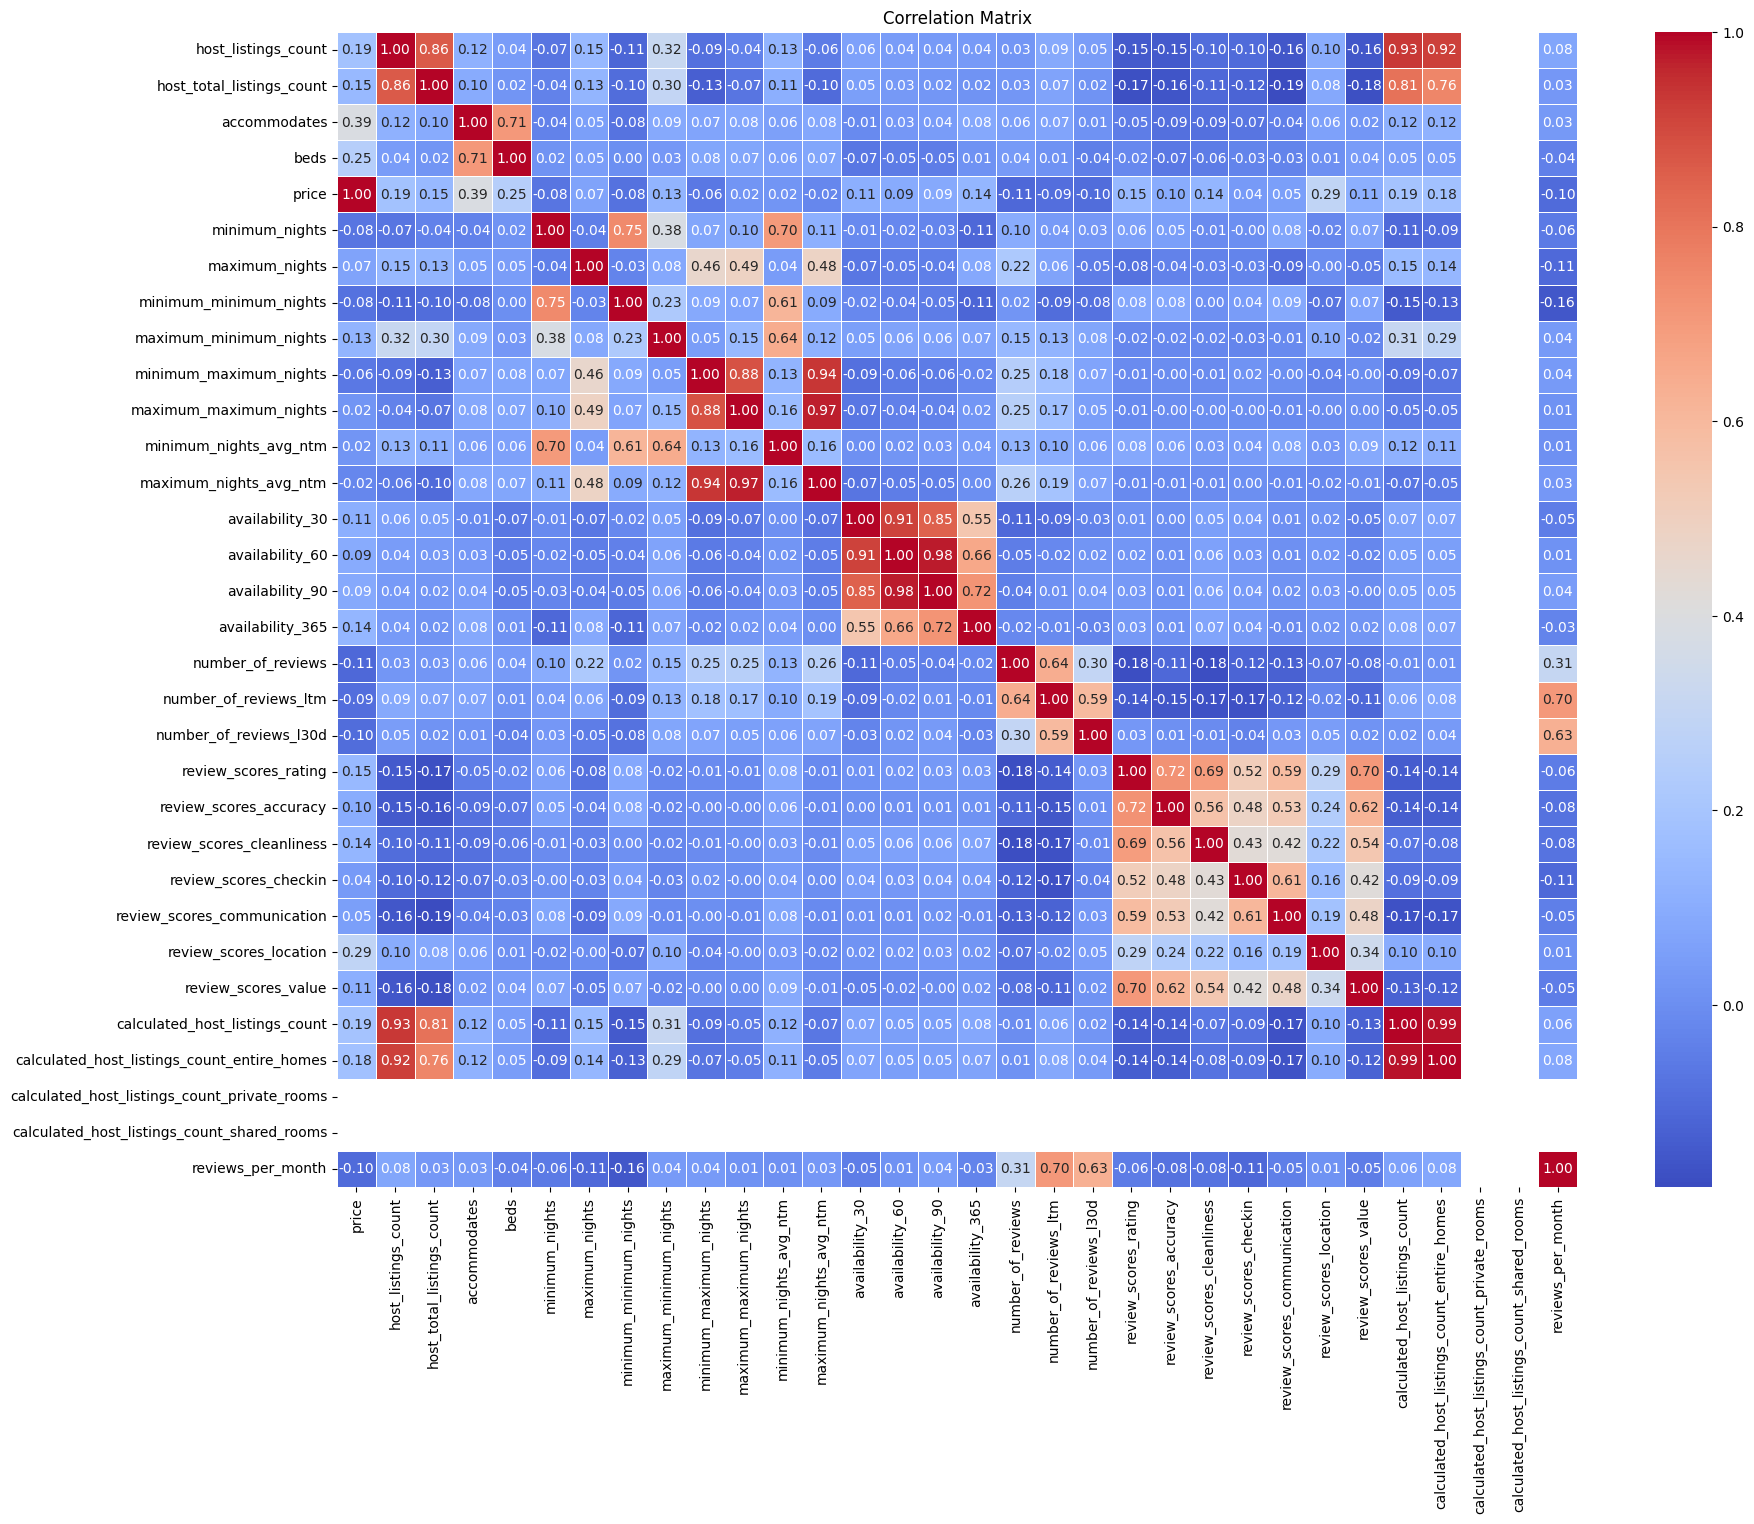

In [ ]:
numeric_variables = df3.select_dtypes(include='number')
correlation_matrix = numeric_variables.corr()

# Move "price" column to the first place
price_corr = correlation_matrix['price'].copy()
correlation_matrix.drop('price', axis=1, inplace=True)
correlation_matrix.insert(0, 'price', price_corr)

correlation_matrix


# Plot correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
price_row = correlation_matrix.loc['price']
price_row.sort_values(ascending=False)

price                                           1.000000
accommodates                                    0.389185
review_scores_location                          0.286369
beds                                            0.250879
calculated_host_listings_count                  0.192450
host_listings_count                             0.186707
calculated_host_listings_count_entire_homes     0.181907
host_total_listings_count                       0.148605
review_scores_rating                            0.148031
review_scores_cleanliness                       0.137272
availability_365                                0.135936
maximum_minimum_nights                          0.127900
availability_30                                 0.108354
review_scores_value                             0.107312
review_scores_accuracy                          0.100213
availability_60                                 0.093197
availability_90                                 0.086751
maximum_nights                 

In [ ]:
# Create an empty list to store the correlated columns
price_correlated_columns = []

# Iterate over each column in the correlation matrix
for column in correlation_matrix.columns:
    # Check if the correlation value is greater than 0.05 and the column is not 'price'
    if abs(correlation_matrix.loc['price', column]) > 0.1 and column != 'price':
        # Add the column name to the list
        price_correlated_columns.append(column)

# Print the list of correlated columns
print(price_correlated_columns)


['host_listings_count', 'host_total_listings_count', 'accommodates', 'beds', 'maximum_minimum_nights', 'availability_30', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes']


In [ ]:
df4=df3[price_correlated_columns].copy()
df4["price"]=df3["price"]
df4


,host_listings_count,host_total_listings_count,accommodates,beds,maximum_minimum_nights,availability_30,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,price
0,2,3,2,1.0,3.0,19,340,34,4.74,4.85,4.79,4.88,4.82,2,2,2063.0
1,14,32,4,2.0,7.0,12,50,185,4.64,4.79,4.64,4.89,4.64,14,14,3163.0
2,9,9,8,2.0,2.0,14,308,45,4.64,4.73,4.61,4.91,4.57,9,9,5793.0
3,4,4,5,2.0,2.0,9,307,179,4.83,4.85,4.73,4.44,4.76,4,4,3914.0
4,4,5,3,2.0,4.0,11,37,135,4.82,4.88,4.74,4.77,4.73,4,4,1184.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2616,1,1,2,2.0,2.0,15,242,0,4.81,4.85,4.82,4.86,4.76,1,1,1844.0
2617,2,6,2,2.0,7.0,0,226,0,4.81,4.85,4.82,4.86,4.76,2,2,1500.0
2618,1,1,2,1.0,1.0,27,267,0,4.81,4.85,4.82,4.86,4.76,1,1,1300.0
2619,1,2,2,4.0,2.0,25,38,0,4.81,4.85,4.82,4.86,4.76,1,1,4500.0


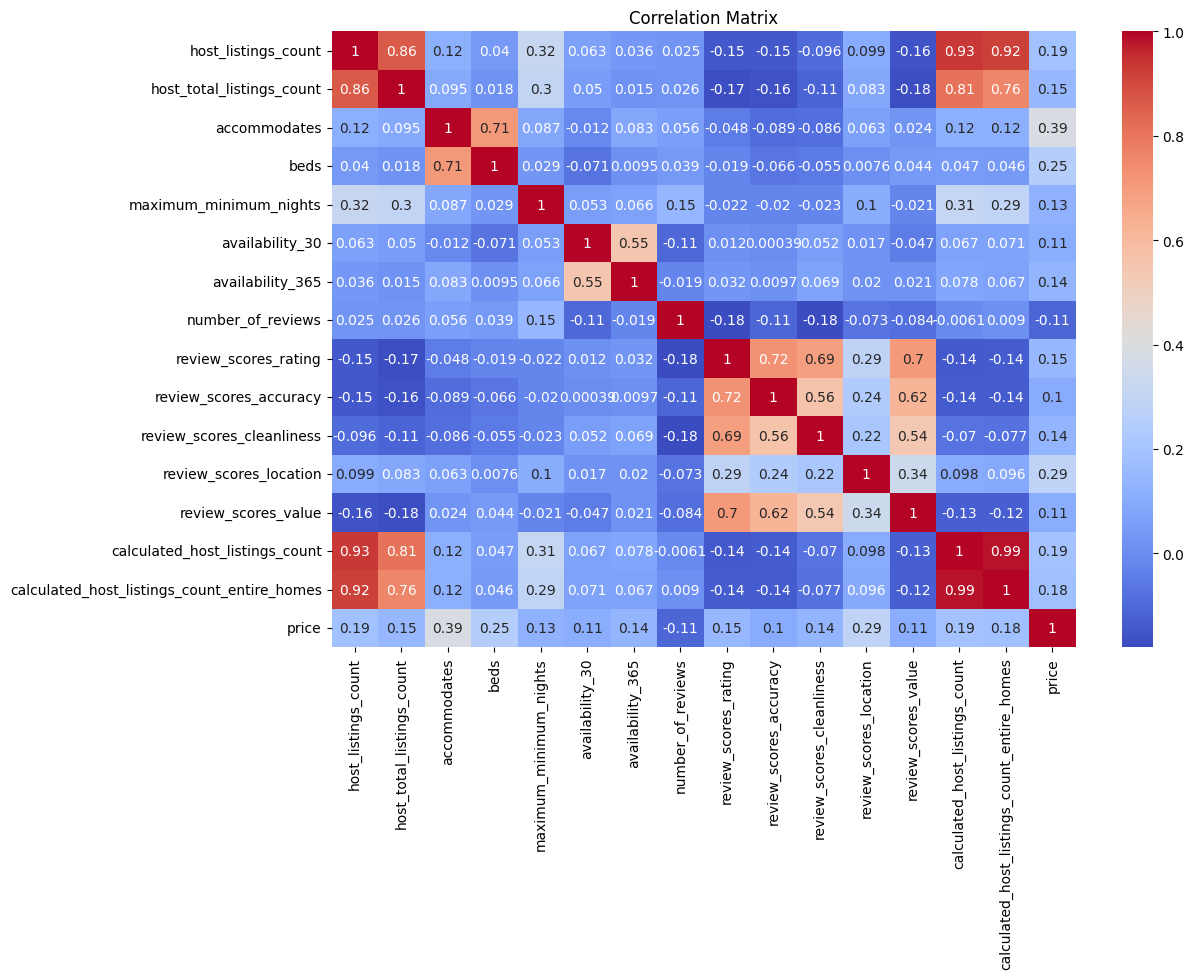

('host_listings_count', 'host_total_listings_count')
('host_listings_count', 'calculated_host_listings_count')
('host_listings_count', 'calculated_host_listings_count_entire_homes')
('host_total_listings_count', 'host_listings_count')
('host_total_listings_count', 'calculated_host_listings_count')
('host_total_listings_count', 'calculated_host_listings_count_entire_homes')
('accommodates', 'beds')
('beds', 'accommodates')
('availability_30', 'availability_365')
('availability_365', 'availability_30')
('review_scores_rating', 'review_scores_accuracy')
('review_scores_rating', 'review_scores_cleanliness')
('review_scores_rating', 'review_scores_value')
('review_scores_accuracy', 'review_scores_rating')
('review_scores_accuracy', 'review_scores_cleanliness')
('review_scores_accuracy', 'review_scores_value')
('review_scores_cleanliness', 'review_scores_rating')
('review_scores_cleanliness', 'review_scores_accuracy')
('review_scores_cleanliness', 'review_scores_value')
('review_scores_value

In [ ]:

correlation_matrix = df4.corr()


# Assuming df4 is the DataFrame containing the data
correlation_matrix = df4.corr()


# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# Filter correlation matrix for absolute correlation greater than 0.5
correlation_threshold = 0.5
filtered_correlation = correlation_matrix.abs() > correlation_threshold

# Get the pairs of variables with correlation greater than 0.5
correlation_pairs = []
for column in filtered_correlation.columns:
    correlated_columns = filtered_correlation[column][filtered_correlation[column]].index.tolist()
    for correlated_column in correlated_columns:
        if correlated_column != column:
            correlation_pairs.append((column, correlated_column))
#
# Print the pairs of variables
for pair in correlation_pairs:
    print(pair)



In [ ]:
seed = 42

In [ ]:

target_variable="price"

# Splitting the data into features (X) and target variable (y)
X = df4.drop(target_variable, axis=1)
y = df4[target_variable]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:


# Fit the linear regression model
model = sm.OLS(y_train, X_train)
results = model.fit(const=True)

# Get the summary of the model
summary = results.summary()

# Print the summary
print(summary)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.863
Model:                            OLS   Adj. R-squared (uncentered):              0.862
Method:                 Least Squares   F-statistic:                              871.2
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        08:50:00   Log-Likelihood:                         -17749.
No. Observations:                2096   AIC:                                  3.553e+04
Df Residuals:                    2081   BIC:                                  3.561e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------

In [ ]:


# Fit a linear regression model
X = df4.drop(target_variable, axis=1)  # Assuming 'target_variable' is the target variable column
y = df4[target_variable]
model = LinearRegression()
model.fit(X, y)

# Get p-values from the linear regression model
X = sm.add_constant(X)  # Add constant term for statsmodels
ols_model = sm.OLS(y, X)
results = ols_model.fit()
p_values = results.pvalues

# Filter df2 to include only significant columns
significant_columns = p_values[p_values < 0.05].index  # Adjust the significance level as needed
significant_columns = significant_columns.drop('const')

df5 = df4[significant_columns].copy()

In [ ]:
df6=df4[["accommodates","review_scores_location","host_total_listings_count","price"]]

In [ ]:

target_variable="price"

# Splitting the data into features (X) and target variable (y)
X = df6.drop(target_variable, axis=1)
y = df6[target_variable]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:


# Fit the linear regression model
model = sm.OLS(y_train, X_train)
results = model.fit(const=True)

# Get the summary of the model
summary = results.summary()

# Print the summary
print(summary)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                              4032.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        08:50:01   Log-Likelihood:                         -17824.
No. Observations:                2096   AIC:                                  3.565e+04
Df Residuals:                    2093   BIC:                                  3.567e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

### final outliers deletion

In [ ]:
# Create df7 as a copy of df2
df7 = df2.copy()

# Calculate lower and upper bounds for each column
lower_bounds = df2.quantile(0.25) - 1.5 * (df2.quantile(0.75) - df2.quantile(0.25))
upper_bounds = df2.quantile(0.75) + 1.5 * (df2.quantile(0.75) - df2.quantile(0.25))

# Apply the filter to df3
for column in ["price","accommodates","review_scores_location","host_total_listings_count"]:
    df7 = df7[(df7[column] >= lower_bounds[column]) & (df7[column] <= upper_bounds[column])]

# Reset the index of df3
df7

,host_listings_count,host_total_listings_count,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2,4,4,4,2.0,3328.0,3,700,3.0,3.0,1125.0,...,4.93,4.93,4.95,4.93,4.89,3,3,0,0,3.28
4,1,5,3,2.0,3766.0,7,365,7.0,7.0,365.0,...,4.79,4.84,4.84,4.90,4.79,1,1,0,0,2.05
9,2,3,2,1.0,2063.0,3,30,1.0,3.0,1125.0,...,4.79,4.82,4.94,4.88,4.82,2,2,0,0,0.38
10,1,2,3,2.0,1002.0,2,21,2.0,2.0,1125.0,...,4.14,4.78,4.83,4.72,4.53,1,1,0,0,1.07
15,14,32,4,4.0,3058.0,3,365,1.0,7.0,365.0,...,4.64,4.51,4.66,4.91,4.59,14,14,0,0,1.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9384,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9385,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48
9386,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,...,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48


In [ ]:
df8=df7[["price","accommodates","review_scores_location","host_total_listings_count"]]

In [ ]:


target_variable="price"

# Splitting the data into features (X) and target variable (y)
X = df8.drop(target_variable, axis=1)
y = df8[target_variable]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:



X_with_const = sm.add_constant(X_train)
# Fit the linear regression model
model = sm.OLS(y_train, X_with_const)

results = model.fit(const=True)

# Get the summary of the model
summary = results.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     600.3
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:50:01   Log-Likelihood:                -42731.
No. Observations:                5042   AIC:                         8.547e+04
Df Residuals:                    5038   BIC:                         8.550e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [ ]:
df8

,price,accommodates,review_scores_location,host_total_listings_count
2,3328.0,4,4.93,4
4,3766.0,3,4.90,5
9,2063.0,2,4.88,3
10,1002.0,3,4.72,2
15,3058.0,4,4.91,32
...,...,...,...,...
9383,936.0,2,4.86,8
9384,936.0,2,4.86,8
9385,936.0,2,4.86,8
9386,936.0,2,4.86,8


### NONUMERICAL

In [ ]:
data_string = data_listings.select_dtypes(exclude=['int64', 'float64'])
pd.set_option('display.max_columns', None)
data_string.describe()


,listing_url,last_scraped,source,name,neighborhood_overview,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,bathrooms_text,amenities,has_availability,calendar_last_scraped,first_review,last_review,instant_bookable
count,9388,9388,9388,9388,4936,9388,9388,9388,9388,7197,5407,8207,8207,8682,9355,9388,9388,8656,9388,9388,9388,4936,9388,9388,9388,9372,9388,8708,9388,8361,8361,9388
unique,9388,1,2,6920,3151,9012,3267,1418,2191,196,1470,4,50,92,2,3116,3116,134,6,2,2,229,51,60,4,32,1,2,1,2610,958,2
top,https://www.airbnb.com/rooms/23163,2023-12-20,city scrape,Rental unit in Praha 1 · ★New · 1 bedroom · 1 ...,The apartment is located in one of the best lo...,https://a0.muscache.com/pictures/799e1836-3bfb...,https://www.airbnb.com/users/show/227945,Prague Days,2010-09-08,"Prague, Czechia","At Prague Days, we believe in recognizing fami...",within an hour,100%,100%,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Staré Město,"['email', 'phone']",t,t,"Hlavní město Praha, Czechia",Praha 1,Entire rental unit,Entire home/apt,1 bath,[],t,2023-12-20,2023-12-03,2023-12-17,t
freq,1,9388,8046,93,31,14,95,191,95,6312,191,6918,6434,4707,5907,360,360,1907,7218,9028,9033,724,3477,5431,7518,5750,9388,8643,9388,53,571,5668


#### Percentages

In [ ]:
# percentages
data_listings['host_acceptance_rate'] = data_listings['host_acceptance_rate'].astype(str).str.replace('%','').astype(float)/100
data_listings['host_response_rate'] = data_listings['host_response_rate'].astype(str).str.replace('%','').astype(float)/100

#### Bathrooms

In [ ]:
data_listings['bathrooms_text'].replace({'Half-bath': '0.5 bath',
                                         'Shared half-bath': '0.5 shared bath',
                                         'Private half-bath': '0.5 private bath'}, inplace=True)

for row in data_listings.index:
    data_listings.loc[row, 'bathrooms'] = str(data_listings.loc[row, 'bathrooms_text']).split(' ')[0]

data_listings['bathrooms'] = data_listings['bathrooms'].astype(float)


In [ ]:
def get_bathroom_type(text):
    if isinstance(text, str):
        if 'private' in text:
            return 'private'
        elif 'shared' in text:
            return 'shared'
    return np.nan

data_listings['bathroom_type'] = data_listings['bathrooms_text'].apply(get_bathroom_type)
data_listings['bathroom_type'].unique()
data_listings = pd.get_dummies(data_listings, columns=['bathroom_type'], drop_first=True)

In [ ]:
data_listings[data_listings.columns[data_listings.dtypes == 'object']] = data_listings[data_listings.columns[data_listings.dtypes == 'object']].astype('category')
print(data_listings.dtypes)

#dummies
data_listings.columns[data_listings.dtypes == 'category']
data_listings = pd.get_dummies(data_listings, columns = ['host_is_superhost','host_has_profile_pic','host_identity_verified','instant_bookable'], drop_first=True)
data_listings = pd.get_dummies(data_listings, columns=['room_type'], prefix='room_type', drop_first=False)
data_listings[data_listings.columns[data_listings.dtypes == 'bool']]


id                                                 int64
listing_url                                     category
scrape_id                                          int64
last_scraped                                    category
source                                          category
                                                  ...   
calculated_host_listings_count_entire_homes        int64
calculated_host_listings_count_private_rooms       int64
calculated_host_listings_count_shared_rooms        int64
reviews_per_month                                float64
bathroom_type_shared                                bool
Length: 76, dtype: object


,bathroom_type_shared,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,instant_bookable_t,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,False,True,True,True,True,True,False,False,False
1,False,True,True,True,True,True,False,False,False
2,False,True,True,True,False,True,False,False,False
3,False,True,True,True,True,True,False,False,False
4,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...
9383,False,False,False,True,True,False,False,True,False
9384,False,False,False,True,True,False,False,True,False
9385,False,False,False,True,True,False,False,True,False
9386,False,False,False,True,True,False,False,True,False


In [ ]:

for row in data_listings.index:
     text = data_listings.loc[row, 'name']
   # Define a regular expression pattern to search for the number of bedrooms
     pattern = r'\b(\d+)\s+bedroom'
   # Search for the pattern in the text
     matches = re.findall(pattern, text)
   # If matches are found, extract the number of bedrooms
     if matches:
        num_bedrooms = int(matches[0])
        data_listings.loc[row,'bedrooms'] = num_bedrooms
     else:
        data_listings.loc[row,'bedrooms'] = np.nan

In [ ]:

# Assuming your DataFrame is named data_listings
prague_center = (50.0755, 14.4378)  # Latitude and longitude of Prague city center

# Define a function to calculate distance
def calculate_distance(row):
    listing_coords = (row['latitude'], row['longitude'])
    distance = geodesic(prague_center, listing_coords).kilometers
    return distance

# Apply the function to create a new column
data_listings['distance_from_city_center_km'] = data_listings.apply(calculate_distance, axis=1)

# Now data_listings has a new column 'distance_from_city_center_km' containing distances from Prague city center




In [ ]:
df9=data_listings[['host_is_superhost_t','host_has_profile_pic_t','host_identity_verified_t','instant_bookable_t',"bedrooms",'bathroom_type_shared','bathrooms',"host_acceptance_rate","host_response_rate",'distance_from_city_center_km','room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']]

In [ ]:

# Merge or join df7 and df9 by their index
merged_df = pd.merge(df7, df9, left_index=True, right_index=True, how='left')



In [ ]:
merged_df.isna().sum().sort_values(ascending=False)

host_response_rate                              634
bedrooms                                        534
host_acceptance_rate                            391
bathrooms                                         9
host_listings_count                               0
host_is_superhost_t                               0
review_scores_location                            0
review_scores_value                               0
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                                 0
instant_bookable_t                                0
host_has_profile_pic_t                            0
host_identity_verified_t                          0
host_total_listings_count                         0
bathroom_type_shared                              0
distance_from_city_center_km                      0
room_type_En

In [ ]:
merged_df.bedrooms.fillna(merged_df.bedrooms.mode()[0], inplace=True)
merged_df.bathrooms.fillna(merged_df.bathrooms.mode()[0], inplace=True)
merged_df.host_response_rate.fillna(merged_df.host_response_rate.median(), inplace=True)
merged_df.host_acceptance_rate.fillna(merged_df.host_acceptance_rate.median(), inplace=True)

In [ ]:
merged_df.isna().sum().sort_values(ascending=False)

host_listings_count                             0
host_identity_verified_t                        0
review_scores_location                          0
review_scores_value                             0
calculated_host_listings_count                  0
calculated_host_listings_count_entire_homes     0
calculated_host_listings_count_private_rooms    0
calculated_host_listings_count_shared_rooms     0
reviews_per_month                               0
host_is_superhost_t                             0
host_has_profile_pic_t                          0
instant_bookable_t                              0
host_total_listings_count                       0
bedrooms                                        0
bathroom_type_shared                            0
bathrooms                                       0
host_acceptance_rate                            0
host_response_rate                              0
distance_from_city_center_km                    0
room_type_Entire home/apt                       0


In [ ]:
final_df=merged_df

In [ ]:
final_df

,host_listings_count,host_total_listings_count,accommodates,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_is_superhost_t,host_has_profile_pic_t,host_identity_verified_t,instant_bookable_t,bedrooms,bathroom_type_shared,bathrooms,host_acceptance_rate,host_response_rate,distance_from_city_center_km,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
2,4,4,4,2.0,3328.0,3,700,3.0,3.0,1125.0,1125.0,3.0,1125.0,5,35,47,47,343,57,5,4.94,4.95,4.93,4.93,4.95,4.93,4.89,3,3,0,0,3.28,True,True,True,False,1.0,False,1.5,1.00,1.0,1.380157,True,False,False,False
4,1,5,3,2.0,3766.0,7,365,7.0,7.0,365.0,365.0,7.0,365.0,27,57,87,362,333,1,0,4.76,4.84,4.79,4.84,4.84,4.90,4.79,1,1,0,0,2.05,False,True,True,False,1.0,False,1.0,0.33,1.0,1.899091,True,False,False,False
9,2,3,2,1.0,2063.0,3,30,1.0,3.0,1125.0,1125.0,2.6,1125.0,19,42,72,340,34,9,0,4.74,4.85,4.79,4.82,4.94,4.88,4.82,2,2,0,0,0.38,True,True,True,False,1.0,False,1.0,1.00,1.0,1.899659,True,False,False,False
10,1,2,3,2.0,1002.0,2,21,2.0,2.0,1125.0,1125.0,2.0,1125.0,5,5,5,145,163,7,0,4.53,4.67,4.14,4.78,4.83,4.72,4.53,1,1,0,0,1.07,False,True,True,True,1.0,False,1.5,0.91,1.0,0.644547,True,False,False,False
15,14,32,4,4.0,3058.0,3,365,1.0,7.0,365.0,365.0,3.0,365.0,0,0,0,0,211,26,1,4.53,4.69,4.64,4.51,4.66,4.91,4.59,14,14,0,0,1.38,True,True,True,False,1.0,False,1.0,0.95,1.0,1.983226,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,26,26,26,26,0,0,0,4.81,4.85,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48,False,False,True,True,1.0,False,1.0,1.00,1.0,0.513098,False,False,True,False
9384,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,25,25,25,25,0,0,0,4.81,4.85,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48,False,False,True,True,1.0,False,1.0,1.00,1.0,1.076801,False,False,True,False
9385,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,30,30,30,30,0,0,0,4.81,4.85,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48,False,False,True,True,1.0,False,1.0,1.00,1.0,1.089213,False,False,True,False
9386,7,8,2,1.0,936.0,1,365,1.0,1.0,365.0,365.0,1.0,365.0,30,30,30,30,0,0,0,4.81,4.85,4.82,4.89,4.90,4.86,4.76,7,0,7,0,1.48,False,False,True,True,1.0,False,1.0,1.00,1.0,1.157033,False,False,True,False


In [ ]:
mdf_col=list(df8.columns)+['host_is_superhost_t','host_has_profile_pic_t','host_identity_verified_t','instant_bookable_t',"bedrooms",'bathroom_type_shared','bathrooms',"host_acceptance_rate","host_response_rate",'distance_from_city_center_km','room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room']

In [ ]:
mdf=final_df[mdf_col]

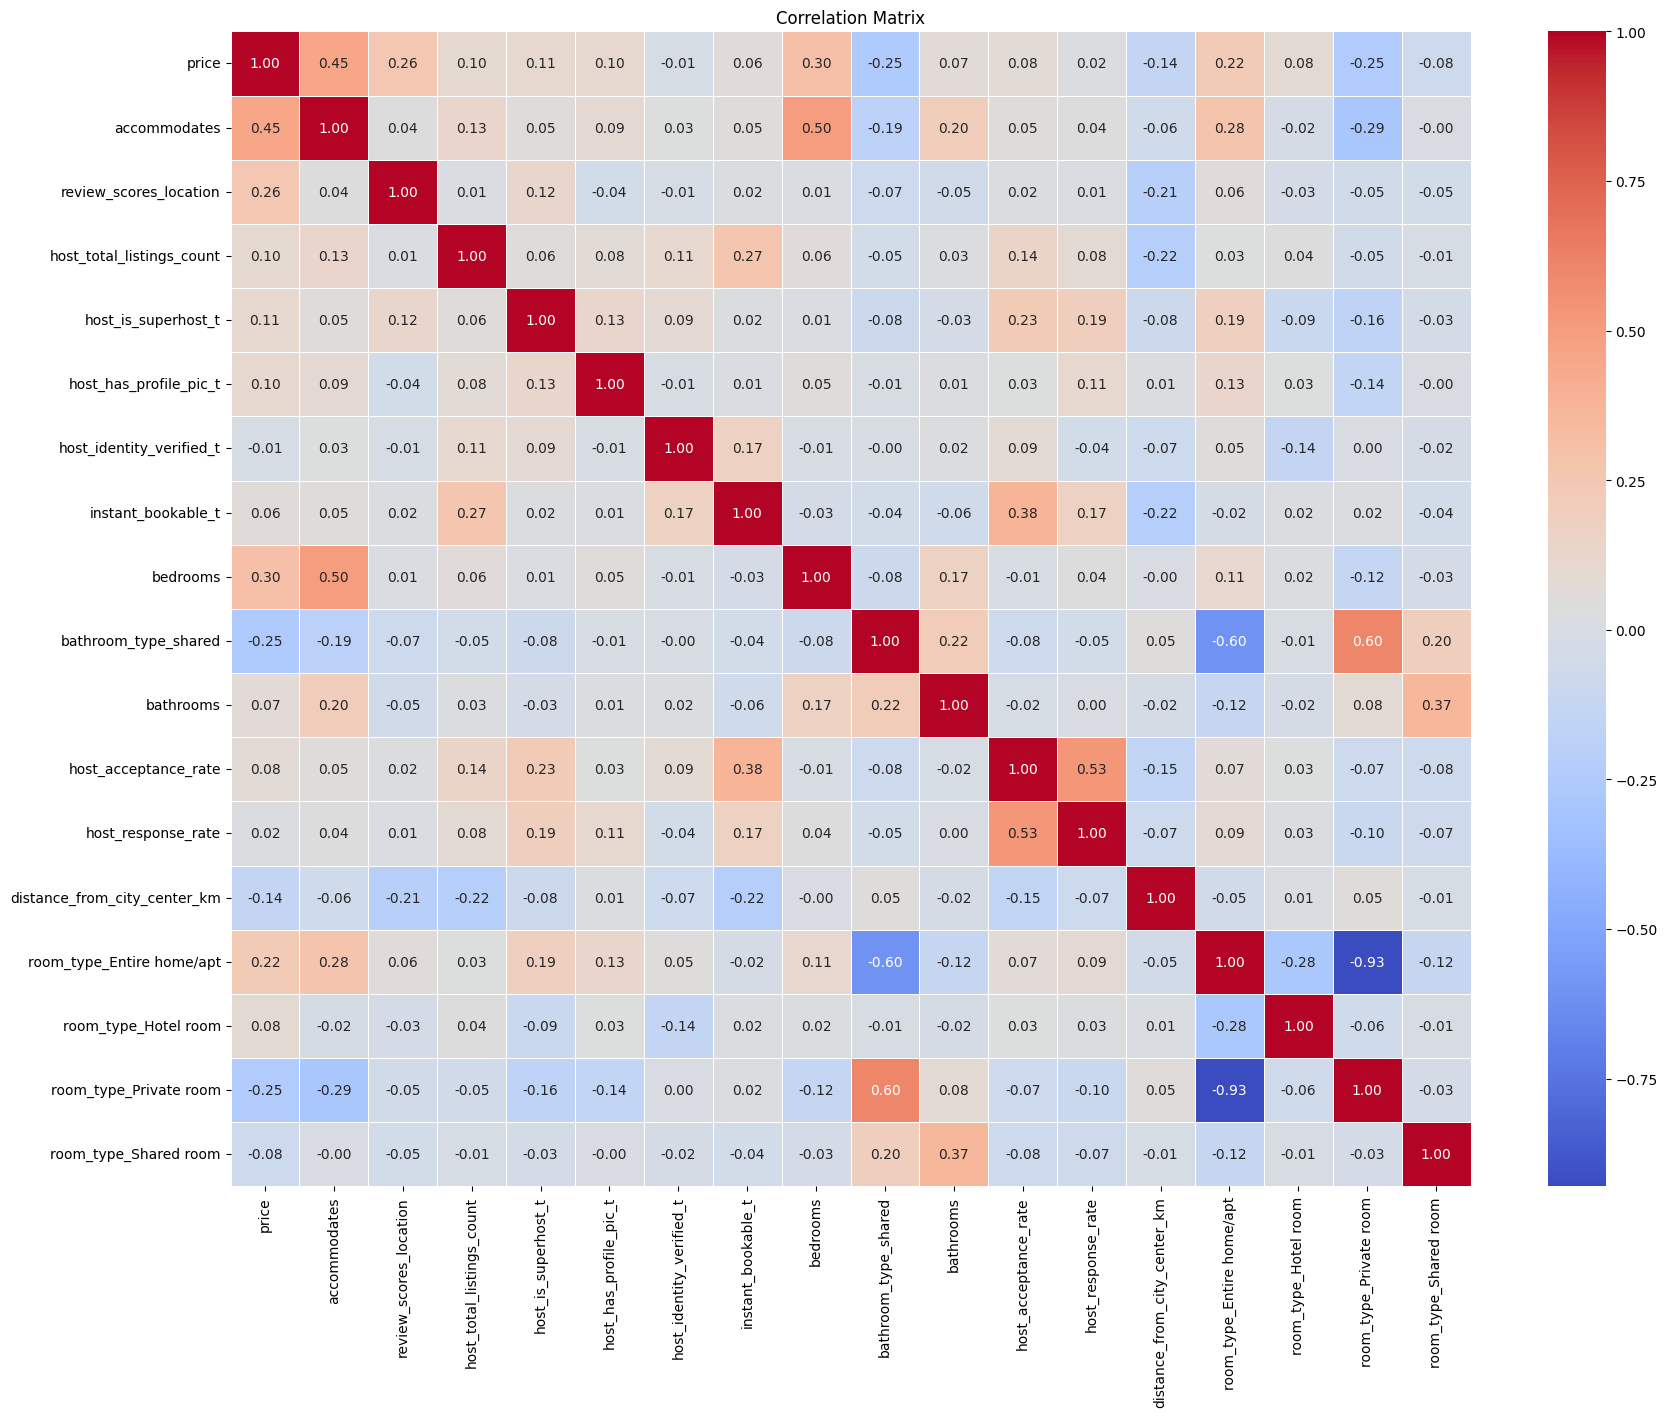

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = mdf.corr()

# Create heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
mdf=mdf*1

In [ ]:
mdf.columns

Index(['price', 'accommodates', 'review_scores_location',
       'host_total_listings_count', 'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'instant_bookable_t', 'bedrooms', 'bathroom_type_shared', 'bathrooms',
       'host_acceptance_rate', 'host_response_rate',
       'distance_from_city_center_km', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')

In [ ]:
mdf_cor=mdf[['price', 'accommodates', 'review_scores_location',
        'host_is_superhost_t',
       'host_has_profile_pic_t', 'host_identity_verified_t',
       'instant_bookable_t', 'bathroom_type_shared', 'bathrooms',
        'host_response_rate',
       'distance_from_city_center_km']]

In [ ]:
mdf=mdf_cor

In [ ]:
# splitting for training and testing
def train_test(data, train_size):
    data_shuffled = data.sample(len(data))
    split_index = int(len(data_shuffled) * train_size)
    train_data = data_shuffled.iloc[:split_index]
    test_data = data_shuffled.iloc[split_index:]
    return train_data, test_data

# mean encoding
def mean_encoding(orig_column, new_column):
        mean_prices_train = train_data.groupby(orig_column)['price'].mean()
        mean_prices_test = test_data.groupby(orig_column)['price'].mean()
        train_data[new_column] = train_data[orig_column].map(mean_prices_train)
        test_data[new_column] = test_data[orig_column].map(mean_prices_test)
        train_data[new_column] = train_data[new_column].astype(float)
        test_data[new_column] = test_data[new_column].astype(float)
        train_data.drop(orig_column, axis=1, inplace=True)
        test_data.drop(orig_column, axis=1, inplace=True)
        return mean_prices_train, mean_prices_test

In [ ]:
final_df=final_df*1

In [ ]:
final_df.columns

Index(['host_listings_count', 'host_total_listings_count', 'accommodates',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_is_superhost_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'ins

In [ ]:
mdf.columns

Index(['price', 'accommodates', 'review_scores_location',
       'host_is_superhost_t', 'host_has_profile_pic_t',
       'host_identity_verified_t', 'instant_bookable_t',
       'bathroom_type_shared', 'bathrooms', 'host_response_rate',
       'distance_from_city_center_km'],
      dtype='object')

In [ ]:
target_variable="price"

# Splitting the data into features (X) and target variable (y)
X = mdf.drop(target_variable, axis=1)
y = mdf[target_variable]

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:


X_with_const = sm.add_constant(X_train)
# Fit the linear regression model
model = sm.OLS(y_train, X_with_const)

results = model.fit(const=True)

# Get the summary of the model
summary = results.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     216.3
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        08:50:10   Log-Likelihood:                -42600.
No. Observations:                5042   AIC:                         8.522e+04
Df Residuals:                    5031   BIC:                         8.529e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [ ]:
target_variable="price"

# Splitting the data into features (X) and target variable (y)
X = mdf.drop(target_variable, axis=1)
y = mdf[target_variable]

# Splitting the data into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### Modelling

In [ ]:
results = pd.DataFrame(columns = ['model','MSE','R^2'])

## Decision trees

In [ ]:
# Single tree
hyper_grid_tree = {'max_depth': [10,12,13,15,17],
                   'min_samples_leaf': [0.008,0.01,0.02],
                    'random_state': [seed]}
tree_model_cv = DecisionTreeRegressor()

grid_search_tree = GridSearchCV(estimator = tree_model_cv, param_grid = hyper_grid_tree, cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')
grid_search_tree.fit(x_train, y_train.values.ravel())

print(grid_search_tree.best_params_)
tree_model_opt = grid_search_tree.best_estimator_

print('MSE: ' + str(abs(grid_search_tree.best_score_)))
print('R: ' + str(tree_model_opt.score(x_train, y_train)))

results = results._append({'model':'single tree',
                           'MSE': abs(grid_search_tree.best_score_),
                           'R^2': tree_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('tree_model.pkl', 'wb') as f:
    pickle.dump(tree_model_opt, f)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'max_depth': 12, 'min_samples_leaf': 0.01, 'random_state': 42}
MSE: 1309146.885448503
R: 0.35230830488761844


In [ ]:
# random forest
hyper_grid_forest = {'n_estimators': [400,800],
              'max_features': [0.1, 0.2, 0.3, 0.4],
              'min_samples_split': [4],
              'max_depth': [15,20,25]}
forest_model_cv = RandomForestRegressor()
grid_search_forest = GridSearchCV(estimator = forest_model_cv, param_grid = hyper_grid_forest, cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

grid_search_forest.fit(x_train, y_train.values.ravel())

print(grid_search_forest.best_params_)
forest_model_opt = grid_search_forest.best_estimator_

print('MSE: ' + str(abs(grid_search_forest.best_score_)))
print('R: ' + str(forest_model_opt.score(x_train, y_train)))

results = results._append({'model':'randoom forest',
                           'MSE': abs(grid_search_forest.best_score_),
                           'R^2': forest_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('forest_model.pkl', 'wb') as f:
    pickle.dump(forest_model_opt, f)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'max_depth': 15, 'max_features': 0.1, 'min_samples_split': 4, 'n_estimators': 800}
MSE: 1146989.1271588847
R: 0.6701999449801509


In [ ]:
# gradient boosting
hyper_grid_gb = {'learning_rate': [0.03,0.05,0.08],
                 'subsample': [0.2,0.6,0.8,1],
                 'max_depth': [5,8,10],
                 'colsample_bytree': [0.3,0.5,0.7],
                 'n_estimators':[150]}

gb_model = xgb.XGBRegressor(seed=seed, objective='reg:squarederror')
grid_search_gb = GridSearchCV(estimator=gb_model,
                        param_grid=hyper_grid_gb,
                        scoring='neg_mean_squared_error',
                        cv=5,
                        verbose=1,
                        n_jobs=-1)

# check evolution of rmse
grid_search_gb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True, early_stopping_rounds=10)
gb_model_opt = grid_search_gb.best_estimator_

gb_model_results = gb_model_opt.evals_result()
epochs = len(gb_model_results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, gb_model_results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, gb_model_results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost RMSE')
plt.show()

hyper_grid_gb = {'learning_rate': [0.03,0.05,0.08],
                 'subsample': [0.2,0.6,0.8,1],
                 'max_depth': [5,8,10],
                 'colsample_bytree': [0.3,0.5,0.7],
                 'n_estimators':[60]}

gb_model = xgb.XGBRegressor(seed=seed, objective='reg:squarederror')
grid_search_gb = GridSearchCV(estimator=gb_model,
                        param_grid=hyper_grid_gb,
                        scoring='neg_mean_squared_error',
                        cv=5,
                        verbose=1,
                        n_jobs=-1)
grid_search_gb.fit(x_train, y_train, eval_set=[(x_train, y_train)], verbose=True, early_stopping_rounds=10)

print(grid_search_gb.best_params_)
gb_model_opt = grid_search_gb.best_estimator_

print('MSE: ' + str(abs(grid_search_gb.best_score_)))
print('R: ' + str(gb_model_opt.score(x_train, y_train)))

results = results._append({'model':'gradient boosting',
                           'MSE': abs(grid_search_gb.best_score_),
                           'R^2': gb_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('gb_model.pkl', 'wb') as f:
    pickle.dump(gb_model_opt, f)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
print(mean_squared_error(y_test,gb_model_opt.predict(x_test),squared=False))


explainer = shap.TreeExplainer(gb_model_opt)
shap_values = explainer(x_train)
shap.summary_plot(shap_values, plot_type='bar')
plt.show()

In [ ]:
shap.summary_plot(shap_values, plot_type = 'dot')
plt.show()

## Regression

In [ ]:
# linear
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

lin_reg.intercept_
lin_reg.coef_

lin_reg_cv = cross_validate(lin_reg, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

pd.DataFrame({'column':x_train.columns.tolist(), 'coef':lin_reg.coef_}) ## tady coef + atribut

print('R: ' + str(lin_reg.score(x_train, y_train)))
print('MSE: ' + str(abs(lin_reg_cv['test_score'].mean())))

results = results._append({'model':'linear reg',
                           'MSE': abs(lin_reg_cv['test_score'].mean()),
                           'R^2': lin_reg.score(x_train, y_train)},ignore_index = True)

with open('linear_model.pkl', 'wb') as f:
    pickle.dump(lin_reg, f)

In [ ]:
# linear ridge
hyper_grid_ridge = {'alpha': [3,5,10,20],
                    'fit_intercept': [True],
                    'random_state': [seed],}
ridge_model_cv = Ridge()
grid_search_ridge = GridSearchCV(estimator = ridge_model_cv, param_grid = hyper_grid_ridge, cv = 5, n_jobs = -1, verbose = 2,scoring='neg_mean_squared_error')

grid_search_ridge.fit(x_train, y_train.values.ravel())

print(grid_search_ridge.best_params_)
ridge_model_opt = grid_search_ridge.best_estimator_

print('R: ' + str(ridge_model_opt.score(x_train, y_train)))
print('MSE: ' + str(abs(grid_search_ridge.best_score_)))

results = results._append({'model':'ridge',
                           'MSE': abs(grid_search_ridge.best_score_),
                           'R^2': ridge_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(ridge_model_opt, f)

In [ ]:
# linear lasso
hyper_grid_lasso = {'alpha': [3,5,10,20],
                    'fit_intercept': [True],
                    'random_state': [seed]}
lasso_model_cv = Lasso()
grid_search_lasso = GridSearchCV(estimator = lasso_model_cv, param_grid = hyper_grid_lasso, cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

grid_search_lasso.fit(x_train, y_train.values.ravel())

print(grid_search_lasso.best_params_)
lasso_model_opt = grid_search_lasso.best_estimator_

pd.DataFrame({'column':x_train.columns.tolist(), 'coef':lasso_model_opt.coef_})

print('R: ' + str(lasso_model_opt.score(x_train, y_train)))
print('MSE: ' + str(abs(grid_search_lasso.best_score_)))

results = results._append({'model':'lasso',
                           'MSE': abs(grid_search_lasso.best_score_),
                           'R^2': lasso_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('lasso_model.pkl', 'wb') as f:
    pickle.dump(lasso_model_opt, f)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'alpha': 3, 'fit_intercept': True, 'random_state': 42}
R: 0.29964664171807875
MSE: 1287763.8744763061


In [ ]:
# linear elasticnet
hyper_grid_elnet = {'l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                    'alpha': [3,4,6,8,10,20,50],
                    'fit_intercept': [True],
                    'random_state': [seed]}
elnet_model_cv = ElasticNet()
grid_search_elnet = GridSearchCV(estimator = elnet_model_cv, param_grid = hyper_grid_elnet, cv = 5, n_jobs = -1, verbose = 2, scoring='neg_mean_squared_error')

grid_search_elnet.fit(x_train, y_train.values.ravel())

print(grid_search_elnet.best_params_)
elnet_model_opt = grid_search_elnet.best_estimator_

print('R: ' + str(elnet_model_opt.score(x_train, y_train)))
print('MSE: ' + str(abs(grid_search_elnet.best_score_)))

results = results._append({'model':'elastic net',
                           'MSE': abs(grid_search_elnet.best_score_),
                           'R^2': elnet_model_opt.score(x_train, y_train)}, ignore_index = True)

with open('elnet_model.pkl', 'wb') as f:
    pickle.dump(elnet_model_opt, f)

## Neural-Net

(5042, 10, 1)
Epoch 1/100
10/10 [==============================] - 3s 93ms/step - loss: 8736389.0000 - mae: 2628.8123 - root_mean_squared_error: 2955.7383 - val_loss: 8719786.0000 - val_mae: 2623.9995 - val_root_mean_squared_error: 2952.9280 - lr: 0.0100
Epoch 2/100
10/10 [==============================] - 0s 31ms/step - loss: 8608690.0000 - mae: 2604.6101 - root_mean_squared_error: 2934.0569 - val_loss: 8493304.0000 - val_mae: 2580.7385 - val_root_mean_squared_error: 2914.3274 - lr: 0.0100
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 8255964.0000 - mae: 2535.6672 - root_mean_squared_error: 2873.3193 - val_loss: 7938849.5000 - val_mae: 2470.2126 - val_root_mean_squared_error: 2817.5964 - lr: 0.0100
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 7499110.5000 - mae: 2377.6221 - root_mean_squared_error: 2738.4507 - val_loss: 6889547.5000 - val_mae: 2242.1863 - val_root_mean_squared_error: 2624.7949 - lr: 0.0100
Epoch 5/100
10/10 [===

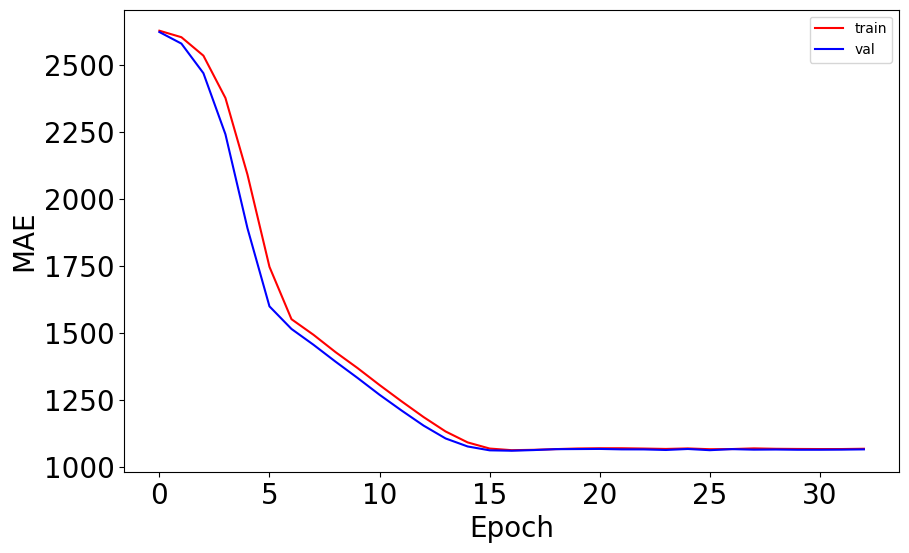

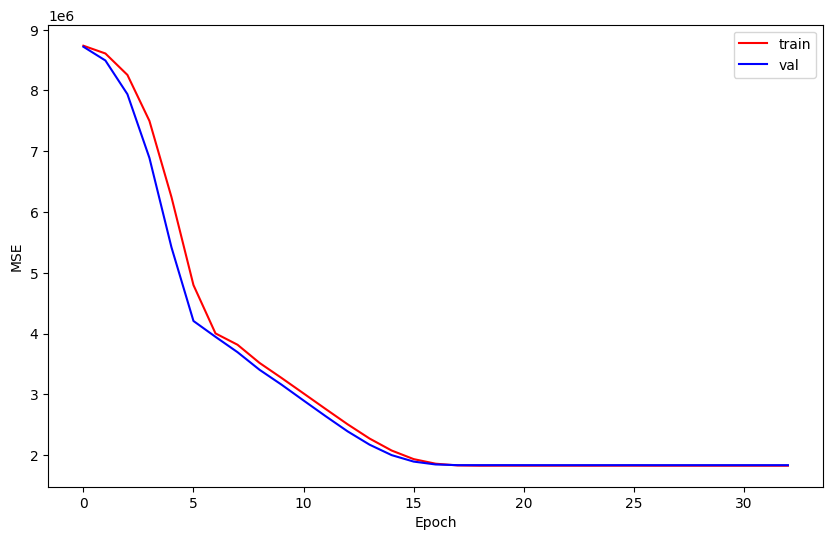

In [ ]:
tf.keras.backend.set_floatx('float32')

# Reshape input data for the model
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)).astype('float32')
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)).astype('float32')

print(x_train_reshaped.shape)

# define the model
model = Sequential()
model.add(Dense(32, input_shape=(x_train_reshaped.shape[1], x_train_reshaped.shape[2])))
model.add(Dense(32))
model.add(Dense(1))

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.01)
rmse = metrics.RootMeanSquaredError()
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', rmse])

# Additional parameters
early_stopping = callbacks.EarlyStopping(patience=10)
learning_rate_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.2)

# Train the model
hist = model.fit(x_train_reshaped, y_train,
                 callbacks=[learning_rate_reducer, early_stopping],
                 batch_size=512,
                 epochs=100,
                 validation_data=(x_test_reshaped, y_test))

# Get model predictions on test data
y_pred = np.mean(np.squeeze(model.predict(x_test_reshaped)), axis=1)

# Calculate MSE and MAE
mae = metrics.mean_absolute_error(y_test, y_pred).numpy()
mse = metrics.mean_squared_error(y_test, y_pred).numpy()

# Calculate R^2 score
r_squared = r2_score(y_test, y_pred)

# Print evaluation metrics
print('MAE: ' + str(abs(mae)))
print('MSE: ' + str(abs(mse)))
print('R^2: ' + str(r_squared))

# Plot MAE
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(hist.history['mae'], 'r', label='train')
ax.plot(hist.history['val_mae'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'MAE', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot MSE
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(hist.history['loss'], 'r', label='train')
ax.plot(hist.history['val_loss'], 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=10)
ax.set_ylabel(r'MSE', fontsize=10)
ax.legend()
ax.tick_params(labelsize=10)

results = results._append({'model':'neural network',
                           'MSE': abs(mse),
                           'R^2': r_squared}, ignore_index = True)

with open('nn_model.pkl', 'wb') as f:
    pickle.dump(hist, f)

## Validation results

In [ ]:
results['RMSE'] = np.sqrt(results['MSE'])
results = results.sort_values('MSE')
print(results)

In [ ]:
results.to_excel('results.xlsx')